In [1]:
import pandas as pd
import os
import json
from scipy.io import wavfile
import glob
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
import librosa
from sklearn.model_selection import train_test_split
import wave
import matplotlib.pyplot as plt
import librosa.display

C:\Users\drake\anaconda3\envs\tf\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Preprocessing

Load Data, going to try out Mel-frequency cepstral coefficients (MFCCs) and spectrograms
Then split data into train test split. (Hopefully will use a nested cross val)

In [2]:
df = pd.read_csv('cough_data.csv')
df.head()

,cough_detected,age,is_female,is_male,COVID-19,symptomatic,season_autumn,season_spring,season_summer,Africa,Asia,Europe,North America,Oceania,South America,file_path,wav_file_name
0,0.6911,31,1,0,0,1,0,1,0,0,0,1,0,0,0,C:\Users\drake\Documents\DL Machine Learning C...,00432f00-2477-4faf-a440-cc1276065b4a.wav
1,0.9751,44,0,1,0,1,0,1,0,0,0,1,0,0,0,C:\Users\drake\Documents\DL Machine Learning C...,008c1c9e-aeef-40c5-846c-24f1b964f884.wav
2,0.9775,17,0,1,0,1,1,0,0,0,0,1,0,0,0,C:\Users\drake\Documents\DL Machine Learning C...,00ac8cb0-3384-46b2-9db5-5b5e911615f0.wav
3,0.9900,41,1,0,0,1,0,1,0,0,0,0,0,0,1,C:\Users\drake\Documents\DL Machine Learning C...,00ce5b06-c302-4387-bbd7-86355a4a8c12.wav
4,0.9632,39,1,0,1,0,1,0,0,0,0,1,0,0,0,C:\Users\drake\Documents\DL Machine Learning C...,01424527-9c3b-4b6e-96f1-9eea3150819b.wav


In [3]:
print(df.loc[2,'file_path'])

C:\Users\drake\Documents\DL Machine Learning Class\Final\coughvid_dataset\00ac8cb0-3384-46b2-9db5-5b5e911615f0.wav


In [4]:
# right now I am going to drop every columns besides 
# COVID-19 (target variable) and File_path (feature/ has the audio wav file)
df = df.drop(columns=[col for col in df.columns if col not in ['COVID-19',
                                                               'file_path']])
df.head(1)

,COVID-19,file_path
0,0,C:\Users\drake\Documents\DL Machine Learning C...


In [5]:
df['COVID-19'].value_counts()

0    1524
1     620
Name: COVID-19, dtype: int64

In [6]:
# setting up features and target variable
X = df.drop('COVID-19',axis=1)
y = df['COVID-19']

# Oversampling since we have few actual covid cases
from imblearn.over_sampling import RandomOverSampler

X_resampled, y_resampled = RandomOverSampler().fit_resample(X, y)

In [7]:
X_resampled.head()

,file_path
0,C:\Users\drake\Documents\DL Machine Learning C...
1,C:\Users\drake\Documents\DL Machine Learning C...
2,C:\Users\drake\Documents\DL Machine Learning C...
3,C:\Users\drake\Documents\DL Machine Learning C...
4,C:\Users\drake\Documents\DL Machine Learning C...


In [8]:
y_resampled.head()

0    0
1    0
2    0
3    0
4    1
Name: COVID-19, dtype: int64

In [9]:
y_resampled.value_counts()

0    1524
1    1524
Name: COVID-19, dtype: int64

In [10]:
pd.set_option('display.max_colwidth', 1000)
X_resampled.iloc[0]

file_path    C:\Users\drake\Documents\DL Machine Learning Class\Final\coughvid_dataset\00432f00-2477-4faf-a440-cc1276065b4a.wav
Name: 0, dtype: object

# Trim 2 Seconds of empty audio space from each audio file

In [46]:
# Only need to run this below code once

In [ ]:
fixed_length = 8 # seconds
silence_duration = 2 # seconds

for index, row in X_resampled.iterrows():
    audio_file_path = row['file_path']
    audio, sr = librosa.load(audio_file_path, sr=None, mono=True)

    # Compute the frame size and hop size in samples
    frame_size = int(sr * silence_duration)
    hop_size = int(frame_size / 2)

    # Trim leading and trailing silence
    audio, _ = librosa.effects.trim(audio, top_db=30, frame_length=frame_size, hop_length=hop_size)

    # If audio is shorter than 8 seconds, pad with zeros
    target_length = int(sr * fixed_length)
    if len(audio) < target_length:
        padded_audio = np.zeros(target_length)
        padded_audio[:len(audio)] = audio
        audio = padded_audio
    else:
        # Truncate to fixed length
        audio = audio[:target_length]

    # Save the processed audio to file
    import soundfile as sf
    sf.write(audio_file_path, audio, sr)


# Wave Form images
Now that the duration of all my .wav audio files are 10 seconds. I am going to see what they look like

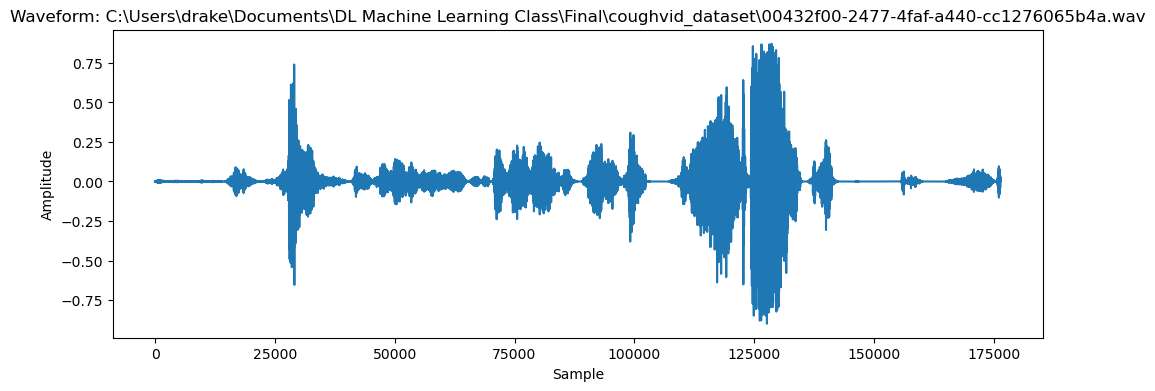

In [14]:
# Load the desired audio file
y, sr = librosa.load(X_resampled.loc[0, 'file_path'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title('Waveform: ' + X_resampled.loc[0, 'file_path'])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

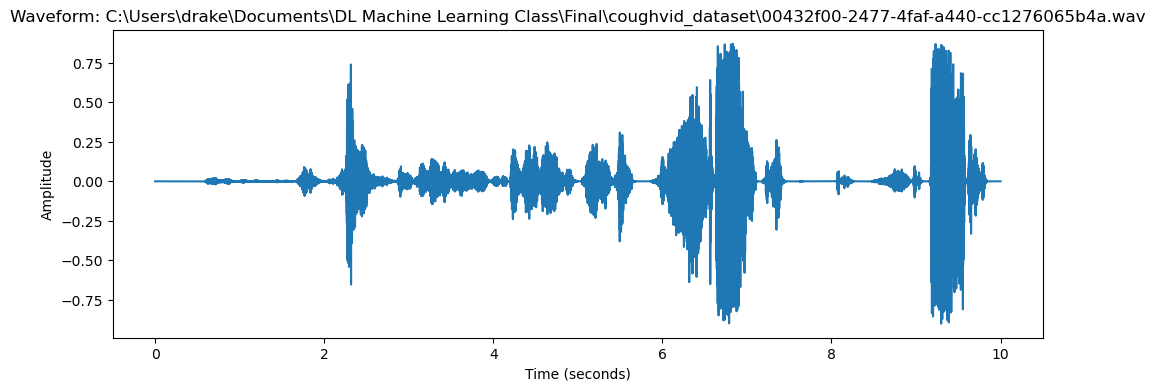

In [16]:
# Load the desired audio file
y, sr = librosa.load(X_resampled.loc[0, 'file_path'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(y))/sr, y)
plt.title('Waveform: ' + X_resampled.loc[0, 'file_path'])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


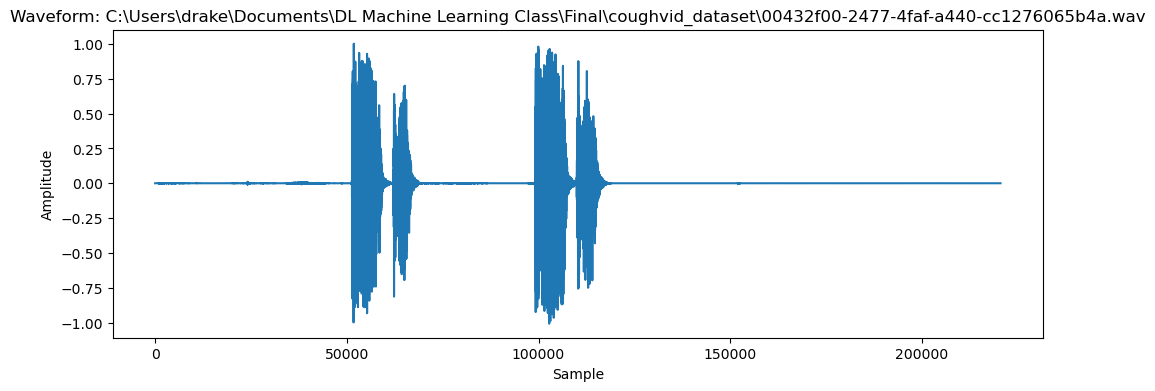

In [17]:
# Load the desired audio file
y, sr = librosa.load(X_resampled.loc[1, 'file_path'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title('Waveform: ' + X_resampled.loc[0, 'file_path'])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

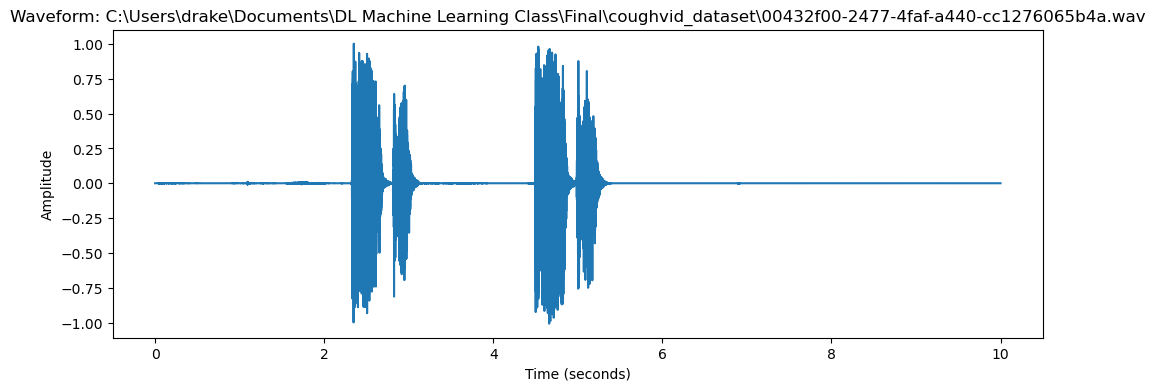

In [18]:
# Load the desired audio file
y, sr = librosa.load(X_resampled.loc[1, 'file_path'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(y))/sr, y)
plt.title('Waveform: ' + X_resampled.loc[0, 'file_path'])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


# Mel Frequency Cepstral Coefficients (MFCCs)
## 8k Hz

# Reshaping Splits so they can fit in LSTM Model

In [15]:
# Define the desired number of MFCC coefficients and time steps
sr = 8000
n_mfcc = 13
hop_length = 512
time_steps = int(10 * sr / hop_length)

# Define a function to extract features from audio files
def extract_features(file_path):
    audio_file, sr = librosa.load(file_path, sr=8000)
    mfccs = librosa.feature.mfcc(y=audio_file, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    return mfccs

# Apply the function to all audio files in the X_resampled dataframe
X_mfccs = X_resampled['file_path'].apply(extract_features)

# Pad or truncate the MFCCs to the desired number of time steps
X_mfccs_padded = []
for mfccs in X_mfccs:
    if mfccs.shape[1] < time_steps:
        padded_mfccs = np.pad(mfccs.T, ((0, time_steps - mfccs.shape[1]), (0, 0)), mode='constant')
        X_mfccs_padded.append(padded_mfccs[:time_steps, :])
    else:
        X_mfccs_padded.append(mfccs.T[:time_steps, :])
X_mfccs = np.array(X_mfccs_padded)

# Reshape the data to fit the input shape of a LSTM model
X_lstm = np.reshape(X_mfccs, (X_mfccs.shape[0], time_steps, n_mfcc))


In [16]:
# checking shapes to make sure above code actually worked
print("X_mfccs shape:", X_mfccs.shape)
print("X_lstm shape:", X_lstm.shape)

X_mfccs shape: (3048, 156, 13)
X_lstm shape: (3048, 156, 13)


# KFOLD SPLIT

# LSTM MODEL

In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support

num_mfcc = X_lstm.shape[2]

# Define the model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(time_steps, num_mfcc), return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create lists to store performance metrics for each fold
acc_scores = []
f1_scores = []
auc_roc_scores = []
precision_scores = []
recall_scores = []
support_scores = []
loss_scores = []
y_preds = []

# Create a KFold object with test split
kf = KFold(n_splits=5, shuffle=True)

# Loop over the folds
for i, (train_idx, val_idx) in enumerate(kf.split(X_mfccs, y_resampled)):
    print(f'Fold {i+1}')
    X_train, y_train = X_mfccs[train_idx], y_resampled[train_idx]
    X_val, y_val = X_mfccs[val_idx], y_resampled[val_idx]

    # Split the validation set into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

    # Reshape the data for the LSTM model
    X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
    X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

    # Train and evaluate the LSTM model on this fold
    history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_lstm)
    y_preds.append(y_pred) # append the predictions
    acc = accuracy_score(y_test, y_pred.round())
    f1 = f1_score(y_test, y_pred.round())
    auc_roc = roc_auc_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred.round())
    test_loss = model.evaluate(X_test_lstm, y_test)[0] # compute test loss and store it
    loss_scores.append(test_loss) # append the test loss to the list of loss scores 
    
    acc_scores.append(acc)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    support_scores.append(support)
    
    print(f'Test Acc={acc}, F1 score={f1}, AUC-ROC={auc_roc}, Precision={precision}, Recall={recall}, Support={support}\n')

# Print the average performance metrics across all folds
print(f'Average Test Acc={np.mean(acc_scores)}, Average F1 score={np.mean(f1_scores)}, Average AUC-ROC={np.mean(auc_roc_scores)}, Average Precision={np.mean(precision_scores)}, Average Recall={np.mean(recall_scores)}, Average Support={np.mean(support_scores, axis=0)}')

Fold 1
Epoch 1/10
77/77 [==============================] - 11s 109ms/step - loss: 0.6925 - accuracy: 0.5135 - val_loss: 0.6781 - val_accuracy: 0.5607
Epoch 2/10
77/77 [==============================] - 8s 101ms/step - loss: 0.6731 - accuracy: 0.5820 - val_loss: 0.6624 - val_accuracy: 0.6230
Epoch 3/10
77/77 [==============================] - 8s 100ms/step - loss: 0.6463 - accuracy: 0.6313 - val_loss: 0.6617 - val_accuracy: 0.6000
Epoch 4/10
77/77 [==============================] - 8s 98ms/step - loss: 0.6074 - accuracy: 0.6649 - val_loss: 0.7442 - val_accuracy: 0.5672
Epoch 5/10
77/77 [==============================] - 8s 108ms/step - loss: 0.5986 - accuracy: 0.6829 - val_loss: 0.6570 - val_accuracy: 0.6033
Epoch 6/10
77/77 [==============================] - 8s 106ms/step - loss: 0.5823 - accuracy: 0.6969 - val_loss: 0.6111 - val_accuracy: 0.6426
Epoch 7/10
77/77 [==============================] - 8s 104ms/step - loss: 0.5344 - accuracy: 0.7449 - val_loss: 0.6624 - val_accuracy: 0.6689

In [18]:
y_prob = model.predict(X_test)
y_prob

10/10 [==============================] - 0s 30ms/step


array([[0.98895925],
       [0.37969908],
       [0.92728084],
       [0.2721431 ],
       [0.01154973],
       [0.01178518],
       [0.38131118],
       [0.10380307],
       [0.9858317 ],
       [0.01204039],
       [0.01205631],
       [0.02594861],
       [0.5163714 ],
       [0.9934067 ],
       [0.5905219 ],
       [0.97258866],
       [0.01134936],
       [0.01110726],
       [0.9930104 ],
       [0.0117899 ],
       [0.99149454],
       [0.9862634 ],
       [0.01197002],
       [0.01112341],
       [0.01114736],
       [0.01187401],
       [0.01158789],
       [0.98766154],
       [0.01997905],
       [0.99338317],
       [0.8798498 ],
       [0.99335444],
       [0.1000177 ],
       [0.3821094 ],
       [0.0116927 ],
       [0.01346418],
       [0.9923157 ],
       [0.01159792],
       [0.38297716],
       [0.986461  ],
       [0.92399734],
       [0.38771293],
       [0.01401398],
       [0.01164185],
       [0.01513086],
       [0.01203611],
       [0.01209798],
       [0.162

In [44]:
y_pred = model.predict(X_test).round()
y_pred

10/10 [==============================] - 0s 27ms/step


array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],

In [45]:
y_pred.shape

(305, 1)

In [19]:
print(f'Train shape: {X_train_lstm.shape}')
print(f'Validation shape: {X_val_lstm.shape}')
print(f'Test shape: {X_test_lstm.shape}')


Train shape: (2439, 156, 13)
Validation shape: (304, 156, 13)
Test shape: (305, 156, 13)


In [24]:
y_pred

array([[0.98895925],
       [0.37969908],
       [0.92728084],
       [0.2721431 ],
       [0.01154973],
       [0.01178518],
       [0.38131118],
       [0.10380307],
       [0.9858317 ],
       [0.01204039],
       [0.01205631],
       [0.02594861],
       [0.5163714 ],
       [0.9934067 ],
       [0.5905219 ],
       [0.97258866],
       [0.01134936],
       [0.01110726],
       [0.9930104 ],
       [0.0117899 ],
       [0.99149454],
       [0.9862634 ],
       [0.01197002],
       [0.01112341],
       [0.01114736],
       [0.01187401],
       [0.01158789],
       [0.98766154],
       [0.01997905],
       [0.99338317],
       [0.8798498 ],
       [0.99335444],
       [0.1000177 ],
       [0.3821094 ],
       [0.0116927 ],
       [0.01346418],
       [0.9923157 ],
       [0.01159792],
       [0.38297716],
       [0.986461  ],
       [0.92399734],
       [0.38771293],
       [0.01401398],
       [0.01164185],
       [0.01513086],
       [0.01203611],
       [0.01209798],
       [0.162

In [25]:
y_pred = model.predict(X_test_lstm)
y_pred

10/10 [==============================] - 0s 31ms/step


array([[0.98895925],
       [0.37969908],
       [0.92728084],
       [0.2721431 ],
       [0.01154973],
       [0.01178518],
       [0.38131118],
       [0.10380307],
       [0.9858317 ],
       [0.01204039],
       [0.01205631],
       [0.02594861],
       [0.5163714 ],
       [0.9934067 ],
       [0.5905219 ],
       [0.97258866],
       [0.01134936],
       [0.01110726],
       [0.9930104 ],
       [0.0117899 ],
       [0.99149454],
       [0.9862634 ],
       [0.01197002],
       [0.01112341],
       [0.01114736],
       [0.01187401],
       [0.01158789],
       [0.98766154],
       [0.01997905],
       [0.99338317],
       [0.8798498 ],
       [0.99335444],
       [0.1000177 ],
       [0.3821094 ],
       [0.0116927 ],
       [0.01346418],
       [0.9923157 ],
       [0.01159792],
       [0.38297716],
       [0.986461  ],
       [0.92399734],
       [0.38771293],
       [0.01401398],
       [0.01164185],
       [0.01513086],
       [0.01203611],
       [0.01209798],
       [0.162

In [22]:
# Print the average test accuracy
print(f'Average Test Acc={np.mean(acc_scores)}')

Average Test Acc=0.8144262295081968


In [23]:
# Print the average AUC-ROC
print(f'Average AUC-ROC={np.mean(auc_roc_scores)}')

Average AUC-ROC=0.8906546192002432


In [28]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


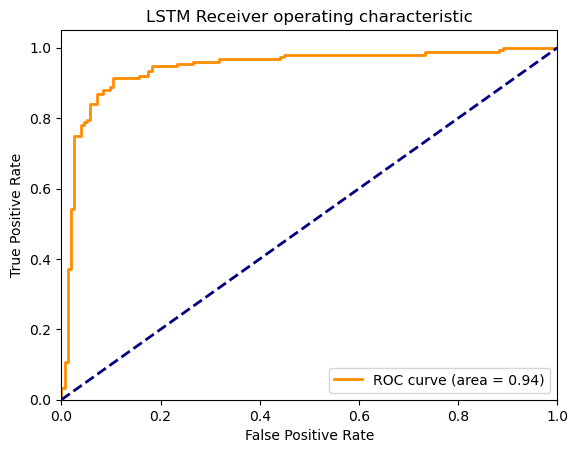

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


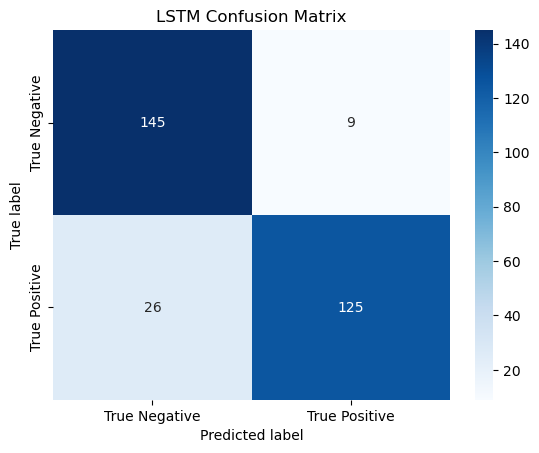

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix
cm = np.array([[145, 9], [26, 125]])

# Create the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True Negative', 'True Positive'], yticklabels=['True Negative', 'True Positive'])

# Set the axis labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('LSTM Confusion Matrix')

# Display the plot
plt.show()


In [36]:
print(f'Average test loss={np.mean(loss_scores)}')

Average test loss=0.40301326513290403


In [34]:
# Print the average F1 score
print(f'Average F1 score={np.mean(f1_scores)}')
# Print the average precision score
print(f'Average Precision score={np.mean(precision_scores)}')
# Print the average recall score
print(f'Average Recall score={np.mean(recall_scores)}')
# Print the average support score
print(f'Average Support score={np.mean(support_scores)}')
# Calculate the confusion matrix and print it out
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred.round())
print(f'Confusion Matrix:\n{cm}\n')

Average F1 score=0.8132617201903962
Average Precision score=0.8218423833735766
Average Recall score=0.8172394127147612
Average Support score=152.5
Confusion Matrix:
[[145   9]
 [ 26 125]]



In [38]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred.round())
print(f'Class 0: Precision={precision[0]}, Recall={recall[0]}, F1 score={f1[0]}, Support={support[0]}')
print(f'Class 1: Precision={precision[1]}, Recall={recall[1]}, F1 score={f1[1]}, Support={support[1]}')


Class 0: Precision=0.847953216374269, Recall=0.9415584415584416, F1 score=0.8923076923076924, Support=154
Class 1: Precision=0.9328358208955224, Recall=0.8278145695364238, F1 score=0.8771929824561403, Support=151
